In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from index_data_handler import IndexDataHandler

# Simulating Returns

In our past analysis we tried to figure out the best portfolio for us. In this analysis we want to see: *What can we expect from a given porfolio?*

Often people look at the mean return per year, lets say 6.5\% and then scale this up by 20 years. While this may give you the mean of the returns it completly ignores the fact that stock returns are highly volatile. It can happen, like in the 70s, that you have a decade of bad performance or like in the 2010s a decade of good performance. This risk should be considered in your analysis.

The next approximation which is often done is to use a normal distribution assumption for the stock returns. While this makes our life as analysts more easy, it may not be a good idea. 

There are two other ways I can come up with which may represent a better way of doing simulation.

The first one is using a bootstrapping technique for the returns. We simply draw a sequence of random past returns and call this a potential future. This allows us to run an arbitrary number of simulations and estimate different worst or best case scenarios.

While this is likely a better approximation of reality than the normal distribution assumption it still lacks an important feature: (auto)Correlation between different months. The worst case scenario for a 10 year period maybe, that we have 120x a 2008-stlye crash. While this is possible to simulate in an uncorrelated world I highly doubt that this is possible. We will explore Marcov-Chain Monte-Calros for a better way of estimating this.

But lets start with: Why a normal distribution is a bad idea.

# The Normal Distribution Flaw



,MSCI World,Value,Quality,Multi-Factor,Momentum,Low Volatility,Small-Cap (Value)
code,990100,705130,702787,706536,703755,129896,139249
region,Developed,Developed,Developed,Developed,Developed,Developed,US
ISIN,IE00BJ0KDQ92,IE00BL25JM42,IE00BL25JL35,IE00BZ0PKT83,IE00BL25JP72,IE00BL25JN58,IE00BSPLC413
vendor,Xtrackers,Xtrackers,Xtrackers,iShares,Xtrackers,Xtrackers,SPDR
ticker,NaN,NaN,NaN,NaN,NaN,NaN,zprv-gy
costs,NaN,NaN,NaN,NaN,NaN,NaN,NaN


reading  MSCI World
reading cache\990100_END_OF_MONTH_19981130.csv
reading  Value
reading cache\705130_END_OF_MONTH_19981130.csv
reading  Quality
reading cache\702787_END_OF_MONTH_19981130.csv
reading  Multi-Factor
reading cache\706536_END_OF_MONTH_19981130.csv
reading  Momentum
reading cache\703755_END_OF_MONTH_19981130.csv
reading  Low Volatility
reading cache\129896_END_OF_MONTH_19981130.csv
reading  Small-Cap (Value)
reading cache\139249_END_OF_MONTH_19981130.csv


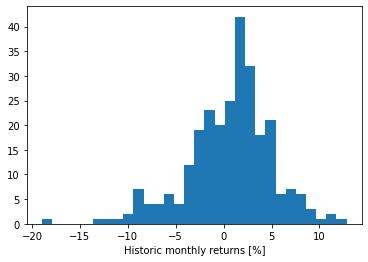

In [2]:
start_date="19981130"
current_index = "MSCI World"
indexHandler = IndexDataHandler(start_date=start_date,frequency="END_OF_MONTH")
index_codes = {**indexHandler.get_available_indices("Developed"), **indexHandler.get_available_indices("US")}
index_codes.pop("Small-Cap")
index_codes.pop("High Dividend")
display(pd.DataFrame.from_dict(index_codes))

def reload_data():
    data = []
    reload=False
    #start_date="20080101"
    for key in index_codes.keys():
        code = index_codes[key]["code"]
        print("reading ",key)
        d = indexHandler.get_historic_stock_data(code, reload=reload)
        d.rename(columns={"level_eod":key}, inplace=True)
        data.append(d)

    df = data[0]
    for i in range(1,len(data)):
        df = df.merge(data[i], how='left',left_index=True,right_index=True)
    return df
df = reload_data()

df['gain'] = df[current_index].pct_change()
df = df.dropna()
plt.xlabel("Historic monthly returns [%]")
plt.hist(df['gain']*100,bins=30)
plt.show()

We can already see from this graph of monthly returns that it does not really look like a normal distribution (bell curve). Especially the lfet hand side tail looks suspicials to me. Lets look at the moments of the distribution and then perform a quick Kolmogorov-Smirnoff test to check for Normal distribution

In [3]:
print(stats.describe(df['gain']))

k2, p =stats.kstest((df['gain']-df['gain'].mean())/df['gain'].std(), 'norm')
print(p)


DescribeResult(nobs=269, minmax=(-0.18934079218009325, 0.12827794756515987), mean=0.006610451372432056, variance=0.001975228683259368, skewness=-0.6212776070314536, kurtosis=1.4862352715166391)
0.18012848232469636


So the skeweness and the kurtosis are both != 0, which means that its likely not a normal distribution. It basically just measures the tails we can already see in the histogram. Additionally the pvalue of the test supports the argument: **Normal distribution is not a good idea.** But how bad is it?

Anyway, lets move on with our analysis. We will use 20 years of horizon and always 50.000 simulated futures.

In [4]:
n = 100000
investment_horizon = 240 #months
quantile_data = pd.DataFrame()

In [5]:
# main function to visualize results later on
def plot_series_aggregate(df,method_name, quantiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]):
    aux = pd.DataFrame() 
    aux['average'] = df.mean(axis=1)
    results = {}
    
    plt.figure(figsize=(15, 10))
    plt.grid(True)
    plt.xlabel("Month")
    plt.ylabel("Balance")
    for q in quantiles:
        name = str(q)+"% quantile"
        aux[str(q)+"% quantile"] = df.quantile(q,axis=1)
        results[str(q)+"% quantile"] = [aux[str(q)+"% quantile"][investment_horizon-1]]
        plt.plot(aux[str(q)+"% quantile"],label=name)
    aux2 = pd.DataFrame(results,index=[method_name])
    display(aux2)
    plt.legend(prop={'size':24})
    return aux2

# Normal Distribution Simulation
Lets simulate the whole thing using a normal distribution assumption. For now we assume a initial investment of 1$/Euro and we see how it performs

In [6]:
mu = df['gain'].mean()
sigma = df['gain'].std()
print("Mean:",mu, "Standard_deviation: ",sigma)
potential_series = {}
for i in range(0,n):
    rnd = np.random.normal(mu,sigma,investment_horizon)+1
    potential_series[i] = rnd.cumprod()
normal_distribution_returns = pd.DataFrame(potential_series)



Mean: 0.006610451372432056 Standard_deviation:  0.04444354489978683


,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
normal,0.769421,1.234065,2.419686,3.843272,6.125194,11.878553,18.778019


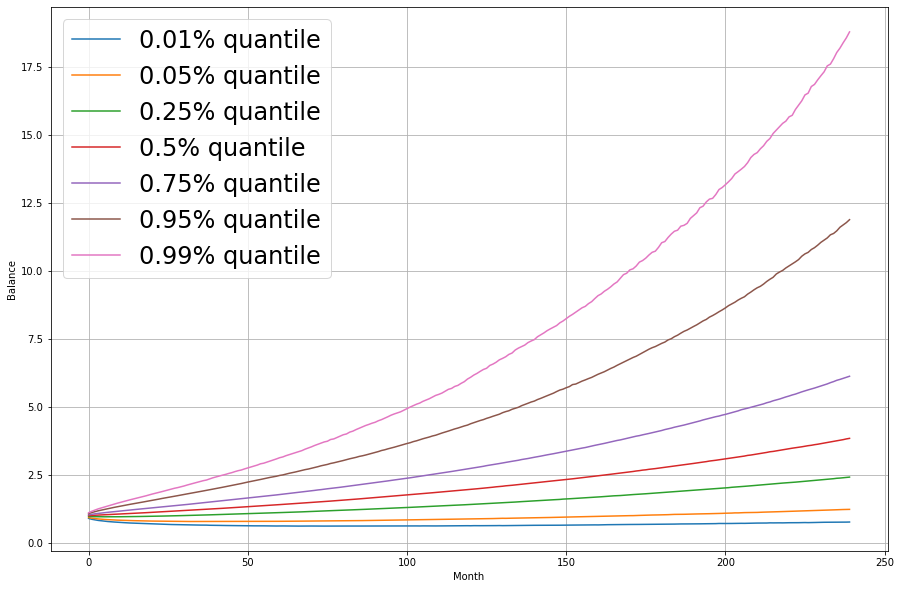

In [7]:
quantile_data=plot_series_aggregate(normal_distribution_returns,method_name="normal")

What can we learn? So in average outcome is that our 1USD becomes 6.77USD. But in 1\% of the cases the 1$ results only in a final portfolio of 1.44USD. This is not even inflation.

# Bootstrapping

In [8]:
def bootstrap(df, name, n):
    df['gain'] = df[name].pct_change()
    potential_series = {}
    potential_gains = {}
    for i in range(0,n):
        aux = df.sample(investment_horizon,replace=True).reset_index()['gain']+1
        potential_series[i] = aux.cumprod()
        potential_gains[i] = aux-1
    bootestrapped_returns = pd.DataFrame(potential_series)
    bootstrapped_gains = pd.DataFrame(potential_gains)
    return bootestrapped_returns, bootstrapped_gains

bootestrapped_returns, bootstrapped_gains = bootstrap(df,"MSCI World",n)
#display(df4)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
bootstrapped,0.712733,1.162038,2.296571,3.680102,5.858156,11.28173,17.718809


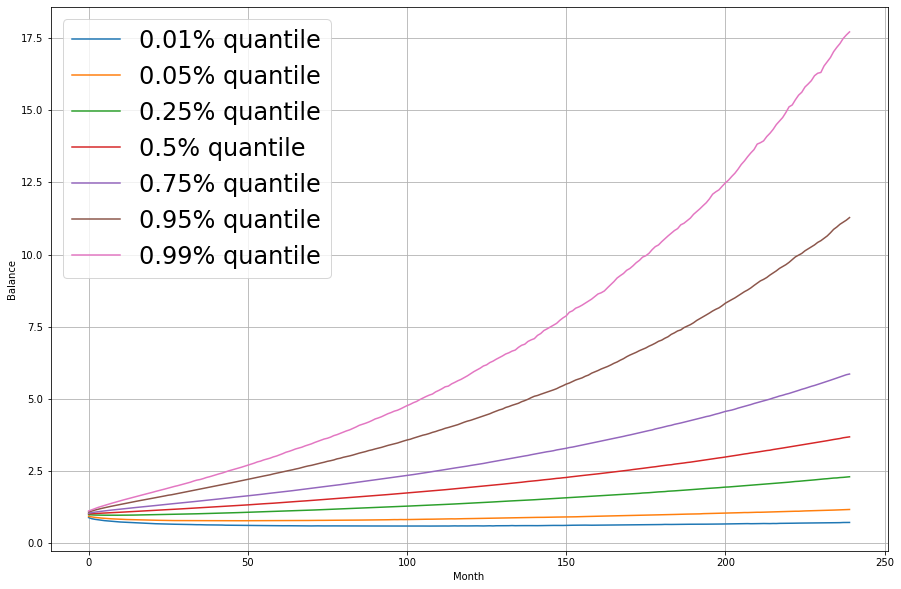

In [9]:
quantile_data = pd.concat([quantile_data,plot_series_aggregate(bootestrapped_returns,'bootstrapped')])

What can we learn? So in average outcome is that our 1USD becomes 6.82USD. But in 1\% of the cases the 1$ results only in a final portfolio of 1.40USD. The mean is slighly higher than the one from the normal distribution and the 1\% quartile is slightly lower


In [10]:
display(quantile_data)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
normal,0.769421,1.234065,2.419686,3.843272,6.125194,11.878553,18.778019
bootstrapped,0.712733,1.162038,2.296571,3.680102,5.858156,11.281730,17.718809


# What happens to Saving Plans?
So far we analyzed a 1-time investment of 1Euro. In reality we more have saving plans. Let's simulate what happens if you invest 1 USD per month over the course of our investment horizon.


In [11]:
def calc_savings_plan(x,monthly_rate=1):
    r = []
    current_balance = monthly_rate
    for v in x:
        current_balance = current_balance*(1+v)+monthly_rate
        #print(v, current_balance)
        r.append(current_balance)
    return pd.Series(r)

In [12]:
simulated_saving_plan_dict = {}
for i in range(0,n):
    simulated_saving_plan_dict[i] = calc_savings_plan(bootstrapped_gains[i],monthly_rate=1)
simulated_savings_df = pd.DataFrame(simulated_saving_plan_dict)


,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
bootstrapped savings,182.846392,243.86218,372.421644,509.167669,698.747282,1115.174537,1568.990287


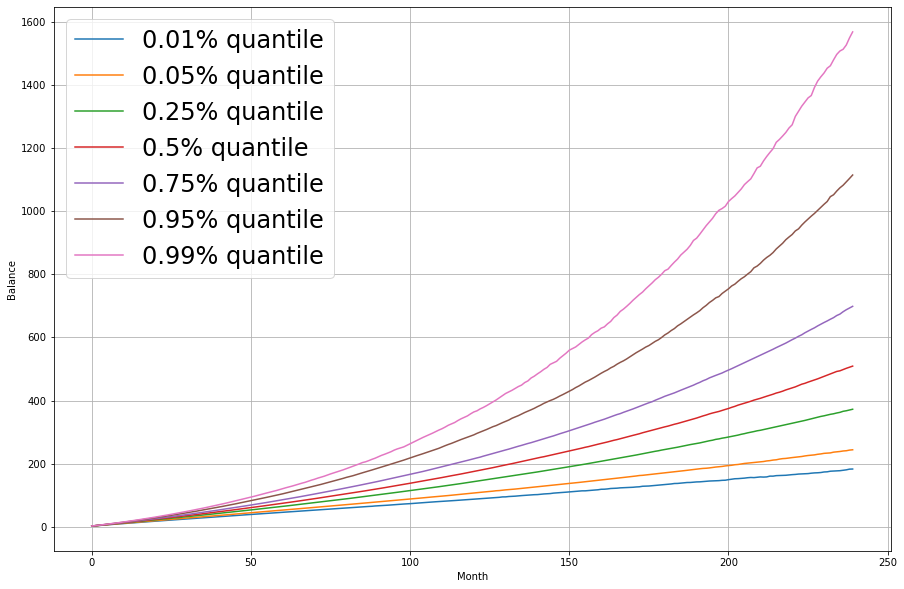

In [13]:
savings_quantiles = plot_series_aggregate(simulated_savings_df,"bootstrapped savings")

Keep in mind that those number include your investment. So off the  173 USD you have on your balance in the median case, 120 are your own capital. 

In [14]:
from asset_allocation import AssetAllocation
index_names = df.columns.tolist()
df = reload_data()
asset_allocations ={}
asset_allocations["Small-Value-Momentum"] = AssetAllocation(index_names).set_allocation_by_dict({"Small-Cap (Value)":0.4,"Momentum":0.2,"Value":0.4})
from factor_estimator import create_index_of_indices
for key, value in asset_allocations.items():
    df = create_index_of_indices(df,key,value)
    
display(df)

reading  MSCI World
reading cache\990100_END_OF_MONTH_19981130.csv
reading  Value
reading cache\705130_END_OF_MONTH_19981130.csv
reading  Quality
reading cache\702787_END_OF_MONTH_19981130.csv
reading  Multi-Factor
reading cache\706536_END_OF_MONTH_19981130.csv
reading  Momentum
reading cache\703755_END_OF_MONTH_19981130.csv
reading  Low Volatility
reading cache\129896_END_OF_MONTH_19981130.csv
reading  Small-Cap (Value)
reading cache\139249_END_OF_MONTH_19981130.csv


,MSCI World,Value,Quality,Multi-Factor,Momentum,Low Volatility,Small-Cap (Value),Small-Value-Momentum
date,,,,,,,,
1998-11-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1998-12-31,1.049005,1.024456,1.067599,1.066349,1.095955,1.048357,1.040312,1.045098
1999-01-29,1.072120,1.039514,1.107618,1.084851,1.147905,1.036790,1.042894,1.062544
1999-02-26,1.043749,0.999014,1.067348,1.054852,1.105298,1.003339,0.956846,1.003404
1999-03-31,1.087360,1.067893,1.103971,1.118971,1.140390,1.021943,0.957336,1.038170
...,...,...,...,...,...,...,...,...
2020-12-31,4.096158,6.395488,6.086429,8.080037,7.778439,4.992752,10.249368,8.213630
2021-01-29,4.056422,6.478542,5.960484,8.078545,7.843048,4.897601,10.907973,8.523215
2021-02-26,4.161735,6.875685,6.034306,8.335578,7.794194,4.819251,11.926663,9.079778


In [15]:
bootestrapped_returns, bootstrapped_gains = bootstrap(df,"Small-Value-Momentum",n)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
factor-bootstrapped,1.118906,2.019117,4.444746,7.687932,13.266217,28.428316,48.894413


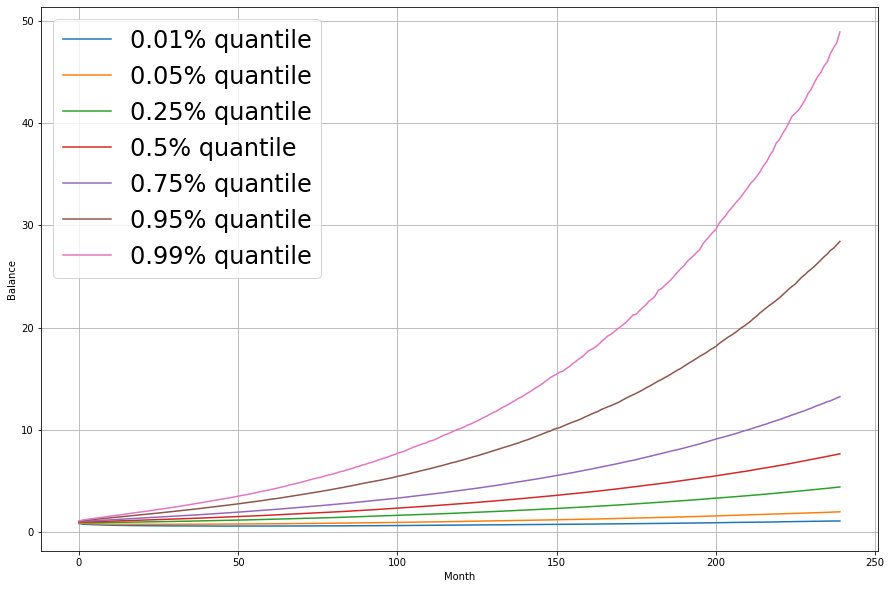

In [16]:
quantile_data = pd.concat([quantile_data,plot_series_aggregate(bootestrapped_returns,'factor-bootstrapped')])

In [17]:
display(quantile_data)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
normal,0.769421,1.234065,2.419686,3.843272,6.125194,11.878553,18.778019
bootstrapped,0.712733,1.162038,2.296571,3.680102,5.858156,11.281730,17.718809
factor-bootstrapped,1.118906,2.019117,4.444746,7.687932,13.266217,28.428316,48.894413


In [18]:
simulated_saving_plan_dict = {}
for i in range(0,n):
    simulated_saving_plan_dict[i] = calc_savings_plan(bootstrapped_gains[i],monthly_rate=1)
simulated_savings_df = pd.DataFrame(simulated_saving_plan_dict)


,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
bootstrapped savings,232.20557,331.319808,558.772297,820.60582,1223.010615,2188.578876,3330.775215


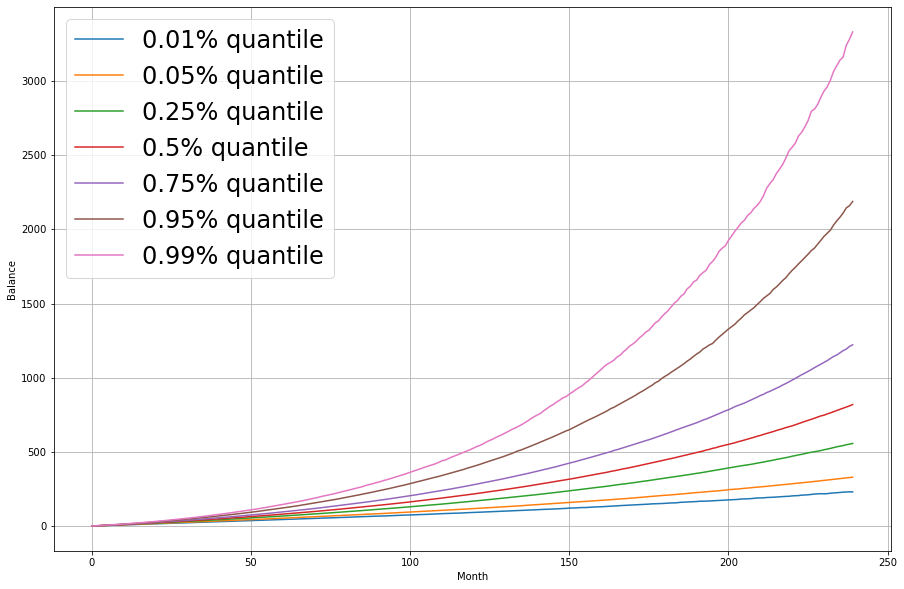

In [19]:
savings_quantiles = plot_series_aggregate(simulated_savings_df,"bootstrapped savings")